# Simple RNN

In ths notebook, we're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!
<img src='assets/time_prediction.png' width=40% />

> * First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

### Import resources and create data 

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First we will create our time series data. Here we will try to predict the next step in a sine wave. This is a good example to start with because it has enough variation to be interesting while we know that it is predictable. The sequence length is how many samples it will look at in one batch of data. In NLP examples, it is the number of words.

In [3]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.shape

(21,)

<Figure size 576x360 with 0 Axes>

Note above that the shape of the data is (21,). We need to add an extra dimension as shown below to work with the RNN.

In [4]:
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension
data.shape

(21, 1)

Now let's plot this data. Here we will take our input (x) to be all of the data except the last point. Our target (y) is then everything excluding the first point. Essentially it is shifted over by one in time. Each has 20 samples and an input size of one.

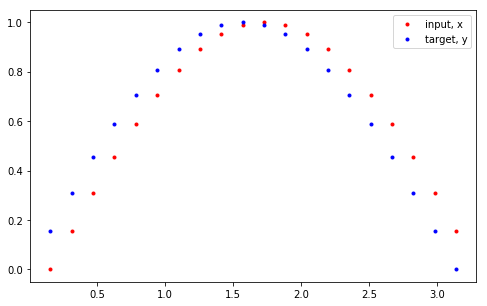

In [2]:
x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In the plot above, y is basically x shifted one sample in the future.

---
## Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input. Note in this example we have 20 samples of size 1 (so input_size=1 in this case).
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


### Check the input and output dimensions

As a check that your model is working as expected, test out how it responds to input data.

In [7]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)
test_rnn

RNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [10]:
# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))
data.shape

(20, 1)

The required input to the RNN has the following dimensions: (batch_size, sequence, features). Here we have a batch size of 1, so we need to create this extra dimension. This can be achieved using `Torch.unsqueeze()`, which assigns a dimension of 1 to the position that we specify. So in the example below, it assigns a dimension of 1 in the first place. The input is now a 3D tensor of shape (1, 20, 1). 

In [12]:
test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())
test_input

Input size:  torch.Size([1, 20, 1])


tensor([[[0.0000e+00],
         [1.6459e-01],
         [3.2470e-01],
         [4.7595e-01],
         [6.1421e-01],
         [7.3572e-01],
         [8.3717e-01],
         [9.1577e-01],
         [9.6940e-01],
         [9.9658e-01],
         [9.9658e-01],
         [9.6940e-01],
         [9.1577e-01],
         [8.3717e-01],
         [7.3572e-01],
         [6.1421e-01],
         [4.7595e-01],
         [3.2470e-01],
         [1.6459e-01],
         [1.2246e-16]]])

We then push this test input through the RNN model. This is what we defined above so it was designed to return the output of the network along with the hidden state. The `None`in the `test_rnn` function means that the initial hidden state is none.

In [13]:
# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


The output is a 2D tensor os hape (20,1). This is because when we set up the model we squeezed the batch size and sequence length into one (batch size = 1 x sequence length =20). The output size is 1. In the hidden state we have a 3D tensor with shape (2,1,10). The first dimension corresponds to the number of layers that make up the RNN which we set to two. The second dimension is the batch size and the final dimension is the hidden dimension that we set to ten.

---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

For the hyperparameters, the input and output size are one since we are just working with one sequence at a time. Th hidden_dim is the number of features you want to generate with the RNN layer. We have set the number of layers to be one for now so we are not stacking RNNs. 

In [14]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error. For regression problems the distance from the true value matters, unlike classification problems where all errors are equally as bad.
* It's typical to use an Adam optimizer for recurrent models.

Note that `rnn.parameters()` contains the weights of the model that we update with the optimizer during training.

In [18]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [19]:
criterion, optimizer

(MSELoss(), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.01
     weight_decay: 0
 ))

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

Note that the below is a bit unconventional as we generate data on the fly. Again we are generating 20 samples of a sine wave function, where y is x shifted one sample in the future.

In [20]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state. Below will initialize as all zeros.
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn


Loss:  0.3959387242794037


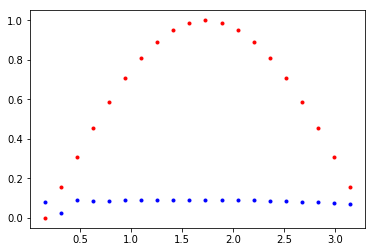

Loss:  0.04664011672139168


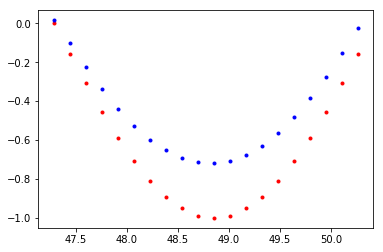

Loss:  0.004593373276293278


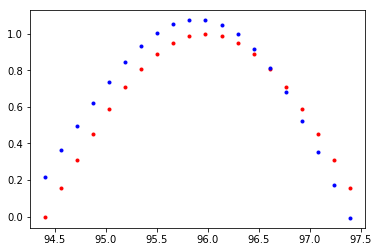

Loss:  0.0006291348836384714


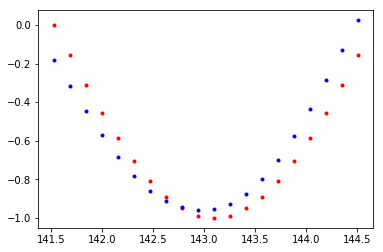

Loss:  0.0002952059148810804


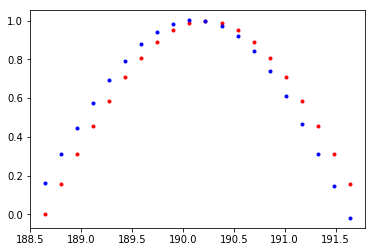

In [21]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

We can see initially that the prediction (blue dots) is poor. After 15 steps we are a lot closer and the loss has reduced. By the end we have a pretty good result. Here the blue should be shifted one sample ahead.

### Time-Series Prediction

Time-series prediction can be applied to many tasks. Think about weather forecasting or predicting the ebb and flow of stock market prices. You can even try to generate predictions much further in the future than just one time step!